# Failure Forecasting using LSTM

### Things to work on

Priority wise after building a baseline model

**BASIC**
- While importing data keep the timestamp in mind till when the data was labelled. (Get Exact from Rahul)
- Handling NAN values
- Reduce Class Values6
- Correctly Scaling the data


**Model**
- Implement Scaling
- Split (Train, Valid and Test)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from library import lib_aws
import pandas as pd
import numpy as np

# PLotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [3]:
# Opttions
pd.set_option('display.max_rows', 500)
mpl.rcParams['figure.figsize'] = (17,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# print(*plt.style.available,sep='\n')

# Import Data

In [4]:
%%time
# Importing failures
# Querying the entire failure info
query_failures = """
SELECT *
FROM
    analysis.failure_info
ORDER BY "NodeID";
"""

with lib_aws.PostgresRDS(db='oasis-prod', verbose=1) as engine:
    failures = pd.read_sql(query_failures, engine, parse_dates=['Failure Start Date', 'Failure End Date'])

well_list = failures.NodeID.unique().tolist()  # List of wells to use for querying the features and model training
failures.head()

Connected to oasis-prod DataBase
Connection Closed
Wall time: 5.46 s


,NodeID,Failure Start Date,Failure End Date,Failures
0,Aagvik 1-35H,2019-10-29 10:43:24,2020-01-05 11:27:10,Tubing - Body
1,Acklins 6092 12-18H,2019-12-22 13:03:58,2020-01-05 04:47:00,Polish Rod
2,Alder 6092 43-8H,2020-03-05 13:28:53,2020-03-14 09:01:01,Pump - Stuck Pump
3,Alder 6092 43-8H,2019-12-20 06:53:56,2020-01-08 08:56:36,Pump - Traveling Valve
4,Andersmadson 5201 42-24 3B,2019-08-12 14:20:29,2019-08-16 18:00:57,Pump - Plunger


In [5]:
# Reducing Number of classes
failures.loc[failures.Failures.str.contains('Tubing'), 'Failures'] = 'Tubing'
failures.loc[failures.Failures.str.contains('Pump'), 'Failures'] = 'Pump'
failures.loc[failures.Failures.str.contains('Rod'), 'Failures'] = 'Rod'
failures.loc[failures.Failures.str.contains('BHA'), 'Failures'] = 'BHA'

In [6]:
%%time
# Import data
# for well_list use only those wells which have been labeled
data_query = """
SELECT
    "NodeID",
    "Date",
    "PPRL",
    "MPRL",
    "FluidLoadonPump",
    "PumpIntakePressure"
FROM xspoc.xdiag
WHERE "NodeID" in {}
ORDER BY "NodeID","Date"
""".format(tuple(well_list))

with lib_aws.PostgresRDS(db='oasis-prod') as engine:
    df = pd.read_sql(data_query, engine, parse_dates=['Date'])
    
well_list_features = df.NodeID.unique()
df.head()

Wall time: 1min 21s


,NodeID,Date,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure
0,Aagvik 1-35H,2019-06-21 15:58:34,27639.0,16811.0,3280.0,NaN
1,Aagvik 1-35H,2019-06-21 16:25:36,27457.0,16752.0,3241.0,NaN
2,Aagvik 1-35H,2019-06-21 18:25:16,27448.0,16594.0,3330.0,NaN
3,Aagvik 1-35H,2019-06-21 18:28:10,27424.0,16595.0,3327.0,NaN
4,Aagvik 1-35H,2019-06-21 20:25:01,27662.0,16711.0,3341.0,NaN


In [7]:
# Use only those wells in failure_info, present in data
failure_info = failures[failures.NodeID.isin(well_list_features)]
failure_info.reset_index(inplace=True, drop=True)

# Understanding the data

Trying out differnt aggregations and features and seeing how the data is spread out:


In [8]:
# Helper Functions
def plot_features(df, well_name, fail_col, feature_cols, mov_avg=None):
    """
    Plots the features and failures of a specific well
    :param df: The data frame we need to use
    :param well_name: Name of the well
    :param fail_col: Failure Column to be considered
    :param feature_cols: Columns to plot as features (Should be numerical)
    :param mov_avg: Plot Moving Averages if needed (Default: None)
    """

    # get the specifc well
    df_well = df[df.NodeID == well_name].reset_index(drop=True)

    # get all the unique failures from the failure col
    fail = df_well[fail_col].unique()
    fail = fail[fail!='Normal']

    # Get only features (for mov_avging)
    if mov_avg is not None:
        df_feature = df_well.set_index('Date')[feature_cols].rolling(mov_avg).mean()
    else:
        df_feature = df_well.set_index("Date")

    # set up the figure
    fig = make_subplots(specs=[[{"secondary_y": True}]])  # secondary y_axis for failures

    # plot features
    for c in feature_cols:
        fig.add_trace(go.Scatter(x=df_feature.index, y=df_feature[c], mode='lines', name=c), secondary_y=False)

    # Plot failures
    for f in fail:
        temp_fail = df_well[fail_col].map(lambda x: 1 if x==f else 0)
        fig.add_trace(go.Scatter(x=df_well.Date, 
                                 y=temp_fail, 
                                 line={
                                     'width':0,
                                     'shape': 'hv'
                                 },
                                 fill='tozerox',
                                 name=f), secondary_y=True)

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(template="seaborn",title=well_name + " with MA of :" + str(mov_avg), autosize=True)
    fig.update_yaxes(title_text="Features (KPI)", secondary_y=False)
    fig.update_yaxes(title_text="Failure", secondary_y=True)

    return fig.show()

# Merging failures with main dataset
# TODO: transfer_cols only works for multiple columns, get it to work with 1 column
def failure_merge(df, failure_df, transfer_cols):
    """
    Merges the failures info
    :param df: dataframe to which info is being transferred to. (Should have columns "NodeID" and "Date")
    :param failure_df: Failure info data (Should have columns "NodeID", "Start Date" and "End Data")
    :param cols: Columns which need to be transferred
    """
    merged = df.copy()  
    for col in transfer_cols:
        merged[col] = 'Normal'  # for now putting everything as normal (even NAN's)
        
    for i in failure_df.index:
        well = failure_df.loc[i, 'NodeID']
        t_start = failure_df.loc[i, 'Failure Start Date']
        t_end = failure_df.loc[i, 'Failure End Date'] + pd.Timedelta('1 day')  # As we have day based frequency (the times in a day are considered as 00:00:00)
        bool_ = (merged.NodeID == well) & (merged.Date >= t_start) & (merged.Date <= t_end)  # Boolean mask for main data
        merged.loc[bool_, transfer_cols] = failure_df.loc[i, transfer_cols].values
        
    return merged

In [ ]:
# # Get percentage of nan values per well
# df_info = (1 - df.groupby('NodeID').count().div(df.groupby('NodeID').size(), axis=0)) * 100
# df_info.drop(columns=['Date']).plot(
#     kind='bar',
#     title='Nan Values Present in Data per well',
#     grid=False,
#     figsize=(75,10)
# )

# # Visualize pct of nan values per KPI
# (df.isnull().sum(axis=0)[2:]/len(df) * 100).plot(
#     kind='bar',
#     title='Nan Values per KPI (%)',
#     figsize=(8,4),
#     grid=False
# #     ylim=(0,100)
# )

In [9]:
# Merge failures with df
transfer_col = ['Failures', 'Failure Start Date']
df = failure_merge(df, failure_info, transfer_col)
df.drop(columns='Failure Start Date', inplace=True)

In [10]:
# For each well what unique failures are present
well_unique_fail = df.groupby('NodeID')['Failures'].agg(['unique'])

# Far each failure type how many wells have seent it
fail_uniq_wells = df.groupby('Failures')['NodeID'].agg(['unique'])

In [12]:
# Visulizing the data
# Chanhe the params in the dictionary below
plot_params = {
    'well_name': 'Kate Evelyn 5501 14-3T',
    'fail_col': 'Failures',
    'feature_cols': ['PPRL', 'MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
    'mov_avg': None
}

plot_features(df=df,**plot_params)

In [17]:
# Check how the data looks after resampling
data = df.groupby('NodeID').resample('6H', on='Date').mean()  # mean Resampling
data.reset_index(inplace=True)
data = failure_merge(data, failure_info, transfer_col)
data.drop(columns='Failure Start Date', inplace=True)

In [18]:
# Visulizing the data
# Chanhe the params in the dictionary below
plot_params = {
    'well_name': 'Kate Evelyn 5501 14-3T',
    'fail_col': 'Failures',
    'feature_cols': ['PPRL', 'MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
    'mov_avg': None
}

plot_features(df=data,**plot_params)

In [48]:
"""
Scaling the Data
"""
from sklearn.preprocessing import StandardScaler

In [122]:
# get a copy from the og data
df_scaled = df.set_index(["NodeID", "Date"])
df_scaled.drop(columns = 'Failures', inplace=True)

# scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(data=scaler.fit_transform(df_scaled), 
                         columns = df_scaled.columns, 
                         index=df_scaled.index)


df_scaled.head()

PPRL      MPRL  FluidLoadonPump  \
NodeID       Date                                                       
Aagvik 1-35H 2019-06-21 15:58:34 -0.880686 -0.003985        -2.018222   
             2019-06-21 16:25:36 -0.932072 -0.032968        -2.038320   
             2019-06-21 18:25:16 -0.934613 -0.110581        -1.992455   
             2019-06-21 18:28:10 -0.941389 -0.110090        -1.994001   
             2019-06-21 20:25:01 -0.874193 -0.053108        -1.986786   

                                  PumpIntakePressure  
NodeID       Date                                     
Aagvik 1-35H 2019-06-21 15:58:34                 NaN  
             2019-06-21 16:25:36                 NaN  
             2019-06-21 18:25:16                 NaN  
             2019-06-21 18:28:10                 NaN  
             2019-06-21 20:25:01                 NaN

In [123]:
# Transfer failures 
df_scaled.reset_index(inplace=True)
df_scaled = failure_merge(df_scaled, failure_info, transfer_col)
df_scaled.drop(columns='Failure Start Date', inplace=True)

In [125]:
# Visulaize
plot_params = {
    'well_name': 'Elm 5892 42-12 1H',
    'fail_col': 'Failures',
    'feature_cols': ['PPRL', 'MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
    'mov_avg': None
}

plot_features(df=df_scaled,**plot_params)

### Notes/Insights 

Looking at the 

# Baseline Model

This basline model will use the previous 30days of data to forecast the calss 7 days in advance. 
For the baseline model we will use the resampled data with a mean aggregation.


**Note: This is an extremely poor choice of feature aggegation**


**Handling NAN Values**
- Filled with 0s

**Steps:**
- Split the data into train and validation
- Window the dataset 
- Train a NN and check the results.

**NN Architecture:**
```
Squential Model

```

In [128]:
data.fillna(0, inplace=True) # Fill NAN's with 0
data.sample(5)

,NodeID,Date,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,Failures
62130,Lydia 5601 43-24T,2019-08-03,0.057735,-0.837779,-0.304584,0.244132,Normal
16828,Daisy May 2758 31-28H,2019-11-16,1.228873,0.120479,0.901829,-0.395117,Normal
22483,Dixie Federal 2758 14-6H,2019-09-22,-0.526569,0.401616,-0.132193,-0.858483,Normal
55421,Kate Evelyn 5501 14-3T,2020-02-26,-0.367872,0.470784,-0.015027,-0.084035,Normal
80046,Rolfson S 5198 11-29 4T,2019-12-28,0.795661,0.393170,0.126047,0.736163,Normal


In [129]:
# Splitting the data into train and validation
# For each well we will keep 70% of the data
# Split accroding to time
# TODO: Make into a function try using vector agg

pct = 0.6 # PCt  of split

train = []
valid = []

for well in data.NodeID.unique():
    temp = data[data.NodeID == well].copy()  # get the well data
    temp.reset_index(inplace=True, drop=True)
    temp.sort_values(by=['Date'], inplace=True)  # Sort by date : IMP
    tr, vl = np.split(temp, [int(pct * len(temp))])  # split 
    train.append(tr)  
    valid.append(vl)
    
train_data = pd.concat(train)
valid_data = pd.concat(valid)

del train, valid, tr, vl, temp  

In [130]:
print(f'Length of Train samples:\t{len(train_data)}\nLength of Validation samples:\t{len(valid_data)}')
print(f'\nLabels Split in train and valid')
_ = pd.concat([train_data.Failures.value_counts(), valid_data.Failures.value_counts()], axis=1, keys=['Train', 'Valid']).fillna(0)
display(_)

Length of Train samples:	58786
Length of Validation samples:	39294

Labels Split in train and valid


,Train,Valid
Normal,54937,38037.0
Pump,1676,317.0
Tubing,1098,723.0
Rod,993,217.0
BHA,82,0.0


In [131]:
# Windowning function
# Using nump arrays
def numpy_window_fn(df, input_size, shift, label_size, feature_cols, label_col):
    """
    :param df: DataFrame
    :param input_size: Size of the input window
    :param shift: Offset from the input window
    :param label_size: The width of labels from the offset
    :feature_cols: Columns in the df to use as features
    :label_col: Column which is the label
    """
    window_size = input_size + shift  # total window 
    label_start = window_size - label_size  # From where the labels start
    
    input_slice = slice(0, input_size)
    input_indices = np.arange(window_size)[input_slice]

    label_slice = slice(label_start, None)
    label_indices = np.arange(window_size)[label_slice]
    
    x = []  # feature matrix
    y = []  # label matrix
    
    # iterate over each well
    for well in df.NodeID.unique():
        temp_df = df[df.NodeID == well].copy()
        temp_df.reset_index(inplace=True, drop=True)
        
        #iterate over each dfpoint in the well
        for i in temp_df.index:
            df_chunk = temp_df.iloc[i: i+window_size]  # Get the full window
            # Check if lenght of the window matches, to avoid smaller windows in the end of the dfset
            if len(df_chunk) == window_size:
                
                # Check if label condition 
                # Window end label is not normal and label start is normla
                # Should be dropped
                if ~((df_chunk.iloc[input_size]['Failures'] != 'Normal') & (df_chunk.iloc[label_start]['Failures'] == 'Normal')):
                    x.append(df_chunk[feature_cols].iloc[0:input_size].values)  # get the input window
                    y.append(df_chunk[label_col].iloc[label_slice].values)  # Get the labels

    x = np.array(x)  # convert to 3-d array
    y = np.array(y)  
    y = y[:,0,:]  # For now only keeping one timestamp ahead predictions (this reshapes it into dfpoints * features)
    
    return x, y

In [132]:
# windowing
window_params = {
    'input_size': 30,
    'shift': 7,
    'label_size': 1,
    'feature_cols': ['PPRL', 'MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
    'label_col': ['Failures']
}

x_train, y_train = numpy_window_fn(train_data, **window_params)  # Training Data
x_valid, y_valid = numpy_window_fn(valid_data, **window_params)  # Validation Data

In [146]:
te_info = pd.DataFrame({'class': np.unique(y_valid, return_counts=True)[0], 'Test Counts': np.unique(y_valid, return_counts=True)[1]})
tr_info = pd.DataFrame({'class': np.unique(y_train, return_counts=True)[0], 'Train Counts': np.unique(y_train, return_counts=True)[1]})



# len(y_valid)
# train_data.head()

pd.concat([tr_info, te_info], axis=1, keys=['Train', 'Valid'])

Train                Valid            
    class Train Counts   class Test Counts
0     BHA           82  Normal     31343.0
1  Normal        47773    Pump       173.0
2    Pump         1676     Rod       127.0
3     Rod          993  Tubing       487.0
4  Tubing         1098     NaN         NaN

In [65]:
# Encoding labels using one-hot-encoder
from sklearn.preprocessing import OneHotEncoder

In [136]:
enc = OneHotEncoder(handle_unknown='ignore')

y_train_enc = enc.fit_transform(y_train).toarray()
y_valid_enc = enc.transform(y_valid).toarray()

## Model

In [137]:
"""
NN PLotting funtions
"""
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.plot(history.epoch,  history.history['loss'],
             color=colors[n], label='Train')
    plt.plot(history.epoch,  history.history['val_loss'],
             color=colors[n], label='Val',
             linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label)
    plt.legend()
    plt.show()
    
def plot_log_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
                 color=colors[n], label='Train')
    plt.semilogy(history.epoch,  history.history['val_loss'],
                 color=colors[n], label='Val',
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss(Logarithmic Scale)')
    plt.title(label)
    plt.legend()
    plt.show()

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        plt.legend()

In [68]:
# Building a baseline model
import tensorflow as tf
from tensorflow import keras

In [138]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

In [140]:
# Params
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

baseline_model = tf.keras.models.Sequential([
    # shape [batch, time, Features]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(5, activation="softmax")
])

baseline_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                       optimizer=keras.optimizers.Adam(),
                       metrics=metrics)

history = baseline_model.fit(
    x_train,
    y_train_enc,
    batch_size=256,
    epochs=10,
    validation_split=0.75,
#     validation_data=(x_valid, y_valid_enc),
    verbose=1
)

Epoch 1/10
51/51 [==============================] - 16s 307ms/step - loss: 0.6509 - accuracy: 0.8540 - precision: 0.9347 - recall: 0.6721 - auc: 0.9483 - val_loss: 0.3638 - val_accuracy: 0.9232 - val_precision: 0.9232 - val_recall: 0.9232 - val_auc: 0.9649
Epoch 2/10
51/51 [==============================] - 17s 324ms/step - loss: 0.3212 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9737 - val_loss: 0.3622 - val_accuracy: 0.9232 - val_precision: 0.9232 - val_recall: 0.9232 - val_auc: 0.9659
Epoch 3/10
51/51 [==============================] - 17s 332ms/step - loss: 0.3119 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9774 - val_loss: 0.3592 - val_accuracy: 0.9232 - val_precision: 0.9232 - val_recall: 0.9232 - val_auc: 0.9685
Epoch 4/10
51/51 [==============================] - 17s 337ms/step - loss: 0.2963 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9816 - val_loss: 0.3668 - val_accuracy: 0.9231 - val_precision: 0.9230 - val_recal

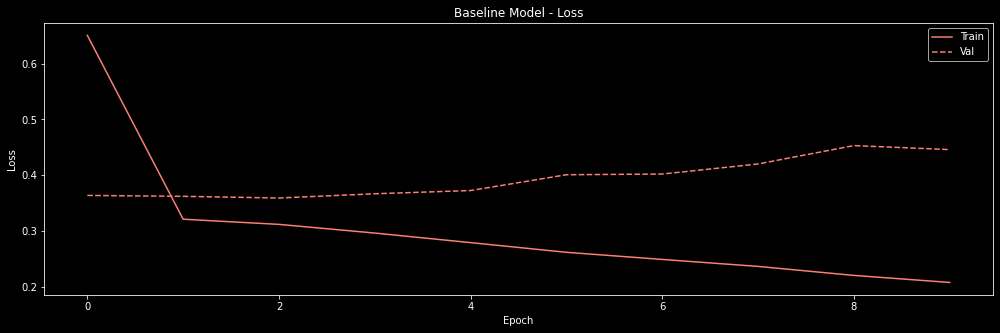

In [141]:
# PLotting Validation Curves
plot_loss(history, 'Baseline Model - Loss', n=3)

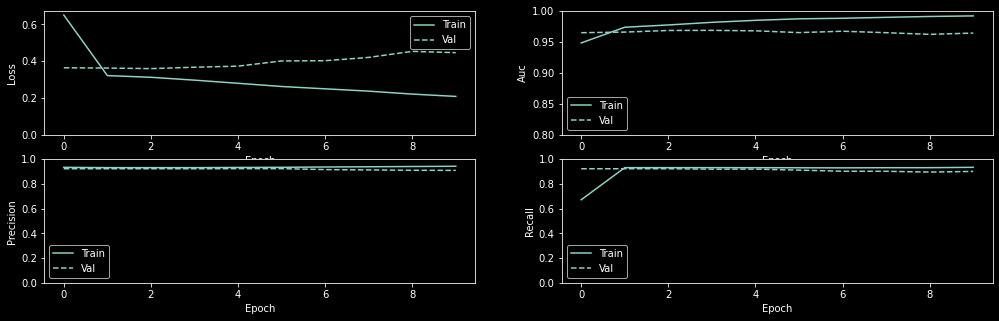

In [142]:
plot_metrics(history)

In [143]:
"""
metrics
"""
# Imports
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, precision_score
from sklearn.metrics import jaccard_score, hamming_loss, classification_report, confusion_matrix

In [106]:
"""
Classes which help with metrics
"""
class BaselineMetrics:
    
    def __init__(self, y_true, y_pred, labels=None):
        self.true = y_true
        self.pred = y_pred
        self.labels = labels
        
    def base_metrics(self):
        # Weighted
        sc = np.array(precision_recall_fscore_support(self.true, self.pred, average='weighted'), \
                      dtype=np.float32).round(4) * 100
        print('Weighted Metrics')
        print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc[0], sc[1], sc[2]))
        
        # macro
        print('\nMacro Metrics')
        sc_macro = np.array(precision_recall_fscore_support(self.true, self.pred, average='macro'), \
                            dtype=np.float32).round(4) * 100
        print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc_macro[0], sc_macro[1], sc_macro[2]))
        
        # Classification Report
        print("\nClassification Report")
        print(classification_report(self.true, self.pred, target_names = self.labels))
        return None
    
    def label_specific_metrics(self):
        """
        Gives label Specific Metrics
        """

        self.label_metrics = pd.DataFrame(data={
            'Jaccard Score': jaccard_score(self.true, self.pred, average=None),
            'Precision': precision_score(self.true, self.pred, average=None),
            'Recall': recall_score(self.true, self.pred, average=None),
            'F1-Score': f1_score(self.true, self.pred, average=None)
        }).round(2)

        if self.labels is not None:
            self.label_metrics.loc[:, 'Labels'] = self.labels
            self.label_metrics.set_index('Labels', inplace=True)
        
        print("\n Label Specific Metrics:")
        print(self.label_metrics)
        return None
  
    def averaged_scores(self):
        """
        Gives averaged out scores
        """
        metric_types = ['weighted', 'macro', 'micro', 'samples']
        self.avg_metrics = pd.DataFrame(index=['Precision', 'Recall', 'F-Score', 'Jaccard-Score'], columns=metric_types)

        for types in metric_types:
            mt = list(precision_recall_fscore_support(self.true, self.pred, average=types))
            mt = [i for i in mt if i]  # Remove nan
            mt.append(jaccard_score(self.true, self.pred, average=types))

            self.avg_metrics.loc[:, types] = mt

        self.avg_metrics = self.avg_metrics * 100
        self.avg_metrics = self.avg_metrics.round(2)
        print("\n Averaged Metrics:")
        print(self.avg_metrics)
        return None

In [144]:
y_hat =  baseline_model.predict(x_valid)
thresh=0.5  # threshold for probabilities, TODO optmize this using F1-score and/or ROC Curve
y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)

In [145]:
# Metrics from BaselineMetrics Class
metrics = BaselineMetrics(y_valid_enc, y_pred)
metrics.base_metrics()
metrics.label_specific_metrics()
metrics.averaged_scores()

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Jaccard i

Weighted Metrics
Precision : 95.32
Recall: 95.83
F-score: 95.57

Macro Metrics
Precision : 20.46
Recall: 20.21
F-score: 20.29

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.98      0.98      0.98     31343
           2       0.00      0.00      0.00       173
           3       0.00      0.00      0.00       127
           4       0.05      0.03      0.04       487

   micro avg       0.97      0.96      0.96     32130
   macro avg       0.20      0.20      0.20     32130
weighted avg       0.95      0.96      0.96     32130
 samples avg       0.96      0.96      0.96     32130


 Label Specific Metrics:
   Jaccard Score  Precision  Recall  F1-Score
0           0.00       0.00    0.00      0.00
1           0.96       0.98    0.98      0.98
2           0.00       0.00    0.00      0.00
3           0.00       0.00    0.00      0.00
4           0.02       0.05    0.03      0.04

 Aver

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-